# The main implementation of thesis project

# Introduction

In this Python notesbook, we choose the following as baselines and evaluate their performances:
- Supervised learning with simple network
- Supervised learning with ResNet50
- Supervised learning with VGG16
- Supervised learning with MobileNet

We then evaluate our self-supervised contrastive model, which uses InfoNCE, known as NT-Xent (Normalized Temperature-scaled Cross Entropy Loss) in SimCLR and used in other works like MoCo. 

The goal of our texture classification model is to train an embedding space constrained by contrastive loss, our model consists of two image augmentation transformers, base encoder, a projection head, and a pure linear regressor with cross-entropy loss as the customised accuracy metric.

# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

# enable GPU
#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#os.environ["RUNFILES_DIR"] = "/usr/local/anaconda3/share/plaidml"
#os.environ["PLAIDML_NATIVE_PATH"] = "/usr/local/anaconda3/lib/libplaidml.dylib"
#import keras

# Setting local library path

Our modules lie in the directory *lib*, we add the path to the library searching path:

In [15]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configurations

In [16]:
#image_size = (128, 128)
image_size = (64, 64) #faster for running on laptop



n_image_channels = 3

#input image shape
image_shape = (*image_size, n_image_channels) 


# sample batch size
batch_size = 128  
#batch_size = 64


# how many epochs
n_epochs = 20

temperature = 0.2
#temperature = 0.5




imgaug_params = { "image_shape": image_shape,
                  "min_area": 0.75, 
                  "brightness": 0.3, 
                  "jitter": 0.1}


# self-supervised contrastive learning
#strong_imgaug_params = {"image_shape": image_shape,
#                             "min_area": 0.25, 
#                             "brightness": 0.6, 
#                             "jitter": 0.2}

# for linear regression based metric
#weak_imgaug_params = { "image_shape": image_shape,
#                            "min_area": 0.75, 
#                            "brightness": 0.3, 
#                            "jitter": 0.1}

# Preparing the dataset

## Loading datasets

In [17]:
train_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 2113
                )

Found 30800 files belonging to 154 classes.


In [18]:
test_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 3371
                )

Found 7700 files belonging to 154 classes.


In [19]:
n_classes = len(train_dataset_.class_names)
print("n_classes = ", n_classes)

n_classes =  154


In [20]:
n_train_samples = len(train_dataset_) * batch_size
n_train_batches = len(train_dataset_)

print("n_train_samples = ", n_train_samples)
print("n_train_batches = ", n_train_batches)

n_train_samples =  30848
n_train_batches =  241


In [21]:
n_test_samples = len(test_dataset_) * batch_size
n_test_batches = len(test_dataset_)

print("n_test_samples = ", n_test_samples)
print("n_test_batches = ", n_test_batches)

n_test_samples =  7808
n_test_batches =  61


In [22]:
n_samples = n_train_samples + n_test_samples
n_batches = n_train_batches + n_test_batches

print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_samples =  38656
n_batches =  302


## Normalising datasets and setting data prefetching

In [23]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

## Verifying loaded dataset

In [24]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([128, 64, 64, 3])

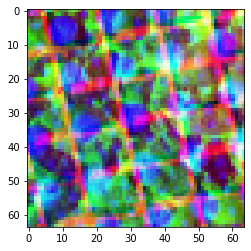

In [25]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

In [26]:
if "imgaug_model" in sys.modules:
    del sys.modules["imgaug_model"]

from imgaug_model import CustomisedTrainImageAugmenter

if "imgaug_viz" in sys.modules:
    del sys.modules["imgaug_viz"]
    
from imgaug_viz import plot_augmented_samples_train

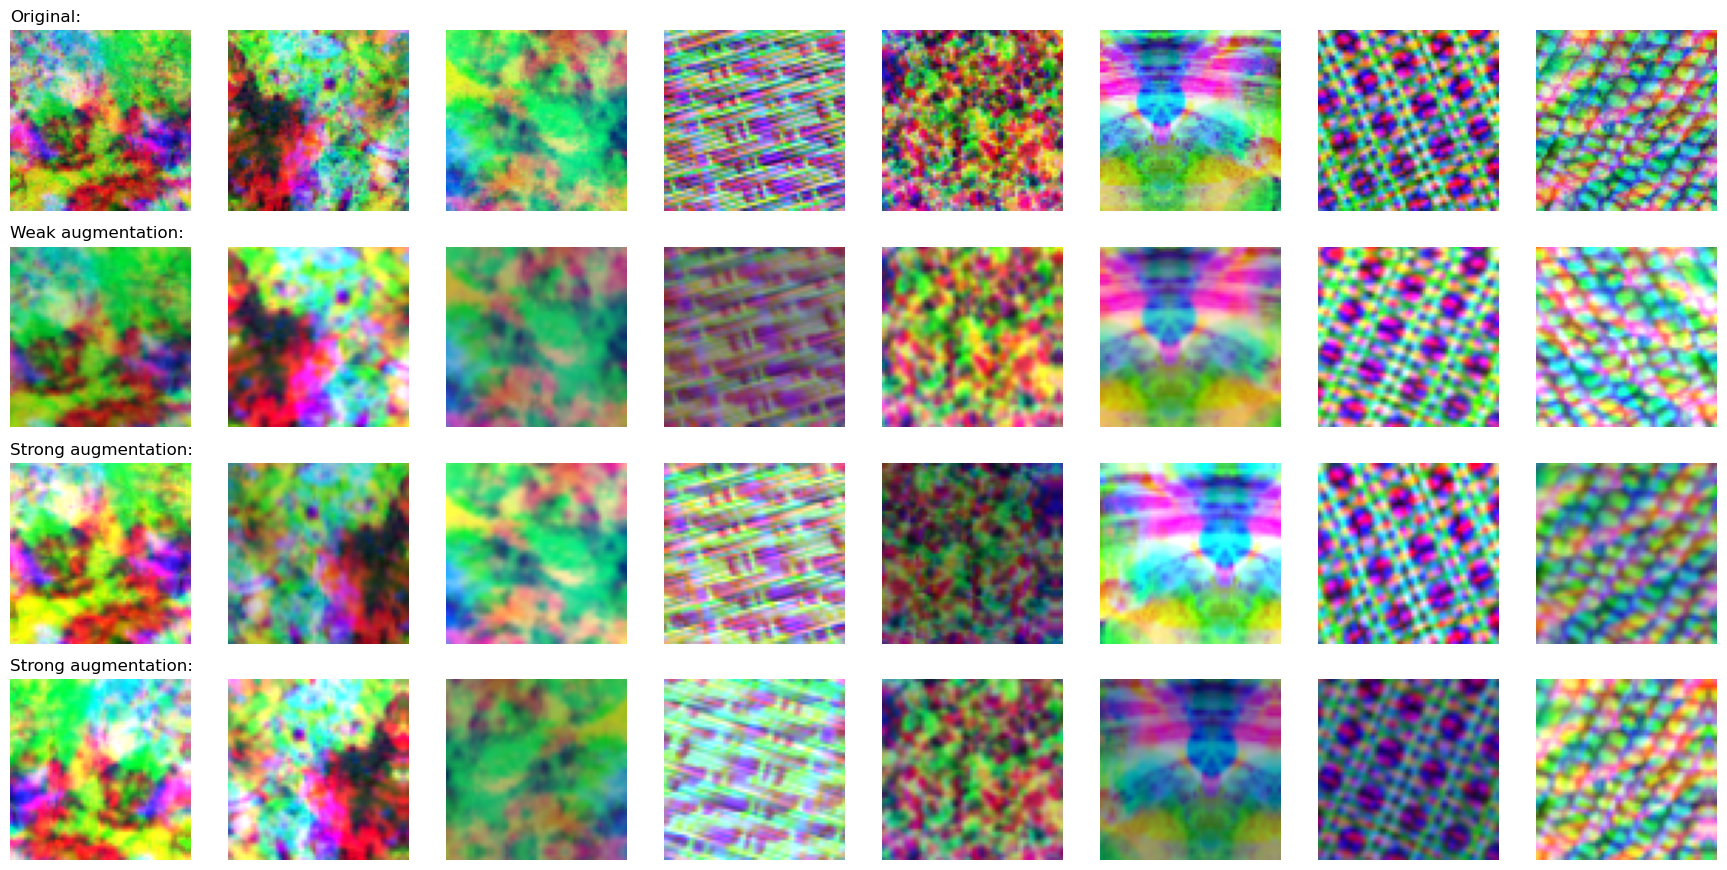

In [27]:
plot_augmented_samples_train(dataset = train_dataset, 
                             n_samples = 8, 
                             strong_imgaug_params = imgaug_params, #strong_imgaug_params, 
                             weak_imgaug_params = imgaug_params,  #weak_imgaug_params, 
                             )

# Simple base encoder

In [28]:
def build_simple_encoder(image_shape):
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape, dtype = "float32"),
            
            keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
            keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Conv2D(128, kernel_size=3, strides=2, activation="relu"),            
            keras.layers.Conv2D(256, kernel_size=3, strides=2, activation="relu"), 
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Flatten(),
            
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
        ],
        
        name = "encoder_simple",
    )

# Building supervised learning model with specified encoder

In [29]:
def build_supervised_model( *,
                            learning_rate = 0.001,
                            image_shape,      
                            n_classes,
                            encoder, 
                            imgaug_params,
                            name
                           ):
    
    newhead = keras.Sequential(
                [
                    keras.layers.Dense(512, activation="relu", name = "hidden_1"),
                    keras.layers.Dense(512, activation="relu", name = "hidden_2"),
                    keras.layers.Dense(n_classes, name = "output"), 
                ], 
                name = "newhead"
            )
            
    
    model = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape = image_shape),
                CustomisedTrainImageAugmenter(**imgaug_params),
                encoder,
                newhead
            ],
            name = name,
        )

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
        )
    
    print()
    newhead.summary()
    
    print()
    encoder.summary()
    
    print()
    model.summary()
    
    return model

# Baseline: Supervised learning with simple encoder

## Building model

In [30]:
baseline_encoder_simple = build_simple_encoder(image_shape)
baseline_model_simple = build_supervised_model(image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_simple, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_simple",
                           learning_rate = 0.001)


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               1180160   
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 1,521,818
Trainable params: 1,521,818
Non-trainable params: 0
_________________________________________________________________

Model: "encoder_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        18496     
_______________________

## Training from scratch

In [31]:
baseline_simple_history = baseline_model_simple.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
 32/241 [==>...........................] - ETA: 28s - loss: 5.0343 - acc: 0.0220

KeyboardInterrupt: 

## Saving models and results

In [76]:
baseline_encoder_simple.save("models/baseline_encoder_simple.saved_model")
baseline_model_simple.save("models/baseline_model_simple.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_simple.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_simple.saved_model/assets


In [77]:
import pickle
import os

if not os.path.exists("results"):
        os.makedirs("results")
        
pickle.dump(baseline_simple_history.history, 
            open("results/baseline_simple_history.pickle", "wb" ))

In [78]:
test_encoder = keras.models.load_model("models/baseline_encoder_simple.saved_model")
test_model = keras.models.load_model("models/baseline_model_simple.saved_model")

del test_encoder
del test_model

In [79]:
history = pickle.load(open(b"results/baseline_simple_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 95.13%
Maximal validation accuracy: 61.48%


## Plotting

In [47]:
import pickle
import matplotlib.pyplot as plt
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap





def plot_supervised_train_accuracy(resultfile):
    
    if not os.path.exists(resultfile):
        return
    
    history = pickle.load(open(resultfile, "rb"))

    val_accs = history["val_acc"]
    train_accs = history["acc"]


    plt.title("The training validation accuracy w.r.t. epochs")

    # https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
    viridis = cm.get_cmap('viridis', 2)
    #newcolors = viridis(np.linspace(0, 1, 2))
    #pink = np.array([248/256, 24/256, 148/256, 1]
    #newcolors[:25, :] = pink
    #newcmp = ListedColormap(newcolors)

    plt.plot(val_accs, color = "blue", label = "validation")
    plt.plot(train_accs, color = "coral", label = "training")

    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Accuracy", fontsize = 12)

    plt.xlim(0, len(val_accs) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_accs) - 1, 
                     num = len(val_accs), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

In [48]:
def plot_supervised_train_loss(resultfile):
    
    if not os.path.exists(resultfile):
        return
    
    history = pickle.load(open(resultfile, "rb"))

    val_loss = history["val_loss"]
    train_loss = history["loss"]

    val_loss = np.array(val_loss) / max(val_loss)
    train_loss = np.array(train_loss) / max(train_loss)

    plt.title("The training validation losses w.r.t. epochs")

    plt.plot(val_loss, color = "blue", label = "validation")
    plt.plot(train_loss, color = "coral", label = "training")

    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)

    plt.xlim(0, len(val_loss) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_loss) - 1, 
                     num = len(val_loss), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

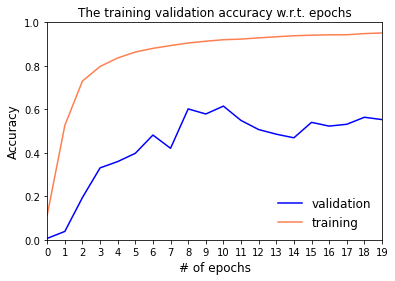

In [49]:
plot_supervised_train_accuracy(b"results/baseline_simple_history.pickle")

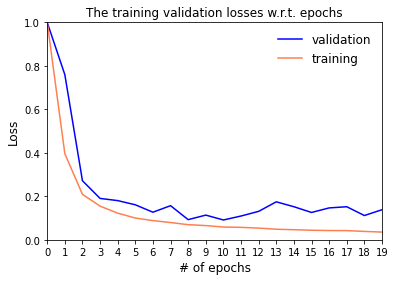

In [50]:
plot_supervised_train_loss(b"results/baseline_simple_history.pickle")

# Baseline: Supervised learning with VGG16

## Building VGG16 encoder

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

def build_vgg16_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
     
    #x = keras.layers.Lambda(vgg16_preprocess_input)(inputs)
    
    model_orig = VGG16(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   

    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "vgg16_encoder")
    
    return model_new

## Building model

In [40]:
baseline_encoder_vgg16 = build_vgg16_encoder(image_shape)
baseline_encoder_vgg16.trainable = False

baseline_model_vgg16 = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_vgg16, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_vgg16",
                           learning_rate = 0.001
                        )


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               262656    
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 604,314
Trainable params: 604,314
Non-trainable params: 0
_________________________________________________________________

Model: "vgg16_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
____________________________

## Training

In [41]:
baseline_vgg16_history = baseline_model_vgg16.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
  1/241 [..............................] - ETA: 10:50 - loss: 5.1339 - acc: 0.0234

KeyboardInterrupt: 

## Saving models and results

In [92]:
baseline_encoder_vgg16.save("models/baseline_encoder_vgg16.saved_model")
baseline_model_vgg16.save("models/baseline_model_vgg16.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_vgg16.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_vgg16.saved_model/assets


In [93]:
test_encoder = keras.models.load_model("models/baseline_encoder_vgg16.saved_model")
test_model = keras.models.load_model("models/baseline_model_vgg16.saved_model")

del test_encoder
del test_model

In [94]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_vgg16_history.history, 
            open("results/baseline_vgg16_history.pickle", "wb" ))

In [95]:
history = pickle.load(open(b"results/baseline_vgg16_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 85.40%
Maximal validation accuracy: 60.66%


## Plotting

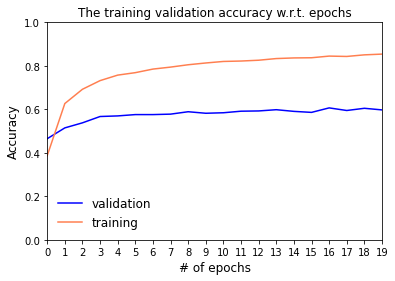

In [42]:
plot_supervised_train_accuracy(b"results/baseline_vgg16_history.pickle")

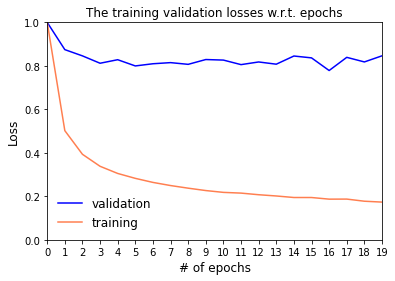

In [43]:
plot_supervised_train_loss(b"results/baseline_vgg16_history.pickle")

# Baseline: Supervised learning with ResNet50

## Building ResNet50 encoder

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

def build_resnet50_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = ResNet50(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "resnet50_encoder")
    
    return model_new

## Building model

In [45]:
baseline_encoder_resnet50 = build_resnet50_encoder(image_shape)
baseline_encoder_resnet50.trainable = False

baseline_model_resnet50 = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_resnet50, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_resnet50",
                           learning_rate = 0.001
                        )


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               1049088   
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 1,390,746
Trainable params: 1,390,746
Non-trainable params: 0
_________________________________________________________________

Model: "resnet50_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 64, 64, 3)]  0                                            
______________________________________________________

## Training

In [46]:
baseline_resnet50_history = baseline_model_resnet50.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20


KeyboardInterrupt: 

## Saving models and results

In [ ]:
baseline_encoder_resnet50.save("models/baseline_encoder_resnet50.saved_model")
baseline_model_resnet50.save("models/baseline_model_resnet50.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/baseline_encoder_resnet50.saved_model")
test_model = keras.models.load_model("models/baseline_model_resnet50.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_resnet50_history.history, 
            open("results/baseline_resnet50_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/baseline_resnet50_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

## Plotting

In [ ]:
plot_supervised_train_accuracy(b"results/baseline_resnet50_history.pickle")

In [ ]:
plot_supervised_train_loss(b"results/baseline_resnet50_history.pickle")

# Baseline: Supervised learning with MobileNet

## Building MobileNet encoder

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input

def build_mobilenet_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = MobileNet(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "mobilenet_encoder")
    
    return model_new

## Building model

In [ ]:
baseline_encoder_mobilenet = build_mobilenet_encoder(image_shape)
baseline_encoder_mobilenet.trainable = False

baseline_model_mobilenet = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_mobilenet, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_mobilenet",
                           learning_rate = 0.001
                        )

## Training

In [ ]:
baseline_mobilenet_history = baseline_model_mobilenet.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

## Saving models and results

In [ ]:
baseline_encoder_mobilenet.save("models/baseline_encoder_mobilenet.saved_model")
baseline_model_mobilenet.save("models/baseline_model_mobilenet.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/baseline_encoder_mobilenet.saved_model")
test_model = keras.models.load_model("models/baseline_model_mobilenet.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_resnet50_history.history, 
            open("results/baseline_mobilenet_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/baseline_mobilenet_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

## Plotting

In [ ]:
plot_train_accuracy(b"results/baseline_mobilenet_history.pickle")

In [ ]:
plot_train_loss(b"results/baseline_mobilenet_history.pickle")

# A general contrastive learning model

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras


class CustomisedContrastiveModel(keras.Model):
    def __init__(self,
                 *,
                 temperature = 0.5,
                 contrastive_loss_func = "nt-xent",
                 
                 encoder = None,
                 train_encoder = True,

                 projhead_hidden_dims = (512, 512,), #one hidden layer by default
                 projhead_output_dim = 512,      #one linear output layer

                 image_augmenter,   

                 n_classes,  #number of classes, used for linear-regression metric
                 
                 
                 **kwargs
                 ):
        
        #super(CustomisedContrastiveModel, self).__init__(**kwargs)
        super(CustomisedContrastiveModel, self).__init__()

        self.temperature = temperature

        #self.contrastive_augmenter = build_augmenter(**contrastive_imgaug_params)
        #self.classification_augmenter = build_augmenter(**classification_imgaug_params)

        #self.contrastive_image_augmenter = contrastive_image_augmenter
        #self.classfication_image_augmenter = classfication_image_augmenter
        
        #self.contrastive_image_augmenter = contrastive_image_augmenter
        #self.classfication_image_augmenter = classfication_image_augmenter

        self.image_augmenter = image_augmenter
        
        self.encoder = encoder
        self.train_encoder = train_encoder
        
        self.n_classes = n_classes
        
        self.projhead_input_shape = self.encoder.layers[-1].output.shape[1]
        self.projhead_hidden_dims = projhead_hidden_dims
        self.projhead_output_dim = projhead_output_dim
        
        print("projhead_input_shape = ", self.projhead_input_shape)
        print("projhead_hidden_dims = ", self.projhead_hidden_dims)
        print("projhead_output_dim = ", self.projhead_output_dim)

        
        """
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(proj_input_shape, )),
                layers.Dense(512, activation="relu"),
                layers.Dense(512), #pure linear
                #layers.BatchNormalization()
            ],
            name="projection_head",
        )
        """

        # build projection head
        self.projhead_model = self.build_projhead_model(
                                input_shape = self.projhead_input_shape,
                                hidden_dims = self.projhead_hidden_dims,
                                output_dim = self.projhead_output_dim
                              )


        # Single dense layer for linear probing
        self.probe_model = self.build_probe_model(
                                n_classes = self.n_classes,
                                input_shape = self.projhead_output_dim
                              )
       
        self.encoder.summary()
        self.projhead_model.summary()
        self.probe_model.summary()

        if contrastive_loss_func == "nt-xent":
            self.contrastive_loss_func = self.ntxent_contrastive_loss_func
        else:
            self.contrastive_loss_func = contrastive_loss_func
     
    """
    
    def get_config(self):
        
        config = super().get_config()

        config["temperature"] = self.temperature
        config["contrastive_loss_func"] = self.contrastive_loss_func
        config["encoder"] = self.encoder
        config["train_encoder"] = self.train_encoder
        config["projhead_hidden_dims"] = self.projhead_hidden_dims
        config["projhead_output_dim"] = self.projhead_output_dim
        config["image_augmenter"] = self.image_augmenter
        config["n_classes"] = self.n_classes
        
        print("config=", config)
        
        return config   
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    """
    
    def build_probe_model(self, *, n_classes, input_shape):
        return keras.Sequential(
                [
                 keras.layers.InputLayer(input_shape = input_shape), 
                 keras.layers.Dense(n_classes), #pure linear
                ], 
                 name="linear_probe"
                )
 
    def build_projhead_model(self, *, input_shape, hidden_dims, output_dim):
        
        inputs = keras.layers.Input(shape = input_shape, name = "projhead_input")

        x = keras.layers.Flatten(name = "projhead_flatten")(inputs)
        
        for idx, dim in enumerate(hidden_dims):
            x = keras.layers.Dense(dim, activation = "swish", name = f"projhead_dense_{idx+1}")(x)

        outputs = keras.layers.Dense(output_dim)(x)

        model = keras.Model(inputs = inputs, outputs = outputs, name = "projhead")

        return model

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):

        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")

        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

        #self.knn_accuracy = keras.metrics.BinaryAccuracy(name="k_acc", threshold=0.5)
        
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker, #contrastive loss
            self.contrastive_accuracy, #contrastive accuracy
            self.probe_loss_tracker, #linear prober loss
            self.probe_accuracy, #linear prober accuracy
            #self.knn_accuracy #kNN accuracy
        ]

    def ntxent_contrastive_loss_func(self, projections_1, projections_2):
        
        # We first normalise the projections for the two batches.
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        # Computing A * B^T, all similarities will be computed at this point.
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        
        fake_labels = tf.range(batch_size)
         
        # Update the projection head accuracy
        self.contrastive_accuracy.update_state(fake_labels, similarities)
        self.contrastive_accuracy.update_state(fake_labels, tf.transpose(similarities))

        # Compute the loss
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, similarities, from_logits=True
        )
        
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, tf.transpose(similarities), from_logits=True
        )

        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
     
        #unpacking the training images and labels (fake) in the batch
        images,labels = data
    
        
        """ The contrastive learning episode
        
        """
        
        # We randomly sample two transformation functions
        # and use them to augment the input batch (N images).
        augmented_images_1 = self.image_augmenter(images)
        augmented_images_2 = self.image_augmenter(images)
        
        
        # We now have 2*N augmented images
        
        
        # tf.GradientTape is a basic facility in tensorflow, which implemented 
        # of recording operations for automatic differentiation..
        #
        # ref: https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # ref:
        
        # Create a GradientTape instance to record the forward process
        with tf.GradientTape() as tape:
            # Feeding augmented images (2*N) into the base encoder
            # to extract their features (2*N)
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            
            # Feeding the features (2*N) into the projection head, which is 
            # a MLP, the final layer is a pure linear layer.
            projections_1 = self.projhead_model(features_1)
            projections_2 = self.projhead_model(features_2)
            
            # We now have 2*N projections from the projection head
            # and compute the contrastive loss (info-NCE)
            contrastive_loss = self.contrastive_loss_func(projections_1, projections_2)
            
        # Computing the gradients w.r.t. every trainable variables by back-propogating the errors    
        # the *gradients* has the results with the form dL / dW
        
        if self.train_encoder:
            gradients = tape.gradient(
                contrastive_loss,
                self.encoder.trainable_weights + self.projhead_model.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.encoder.trainable_weights + self.projhead_model.trainable_weights,
                )
            )
        else:
            gradients = tape.gradient(
                contrastive_loss,
                self.projhead_model.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.projhead_model.trainable_weights,
                )
            )
            
        # Updating the loss history.
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        """ Updating the weights of the linear prediction model
        
        """
                        
        augmented_images_3 = self.image_augmenter(images)
        
        # Forward
        with tf.GradientTape() as tape:
            
            features = self.encoder(augmented_images_3)
            
            features_2 = self.projhead_model(features)
                      
            class_logits = self.probe_model(features_2)
            
            probe_loss = self.probe_loss(labels, class_logits)
            
            
        # backwards, computing the gradients w.r.t. the linear prober
        gradients = tape.gradient(probe_loss, self.probe_model.trainable_weights)
        
        # updating the weights.
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.probe_model.trainable_weights)
        )
        
        # updating history.
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        
        images, labels = data

        augmented_images = self.image_augmenter(images, training=False)
        
        features = self.encoder(augmented_images, training=False)
        features_2 = self.projhead_model(features, training=False)
        
        class_logits = self.probe_model(features_2, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

                
        return {m.name: m.result() for m in self.metrics[2:]}

    #@tf.function
    def call(self, inputs, training = False, mask = None):
        
        augmented_images = self.image_augmenter(inputs)
        features = self.encoder(augmented_images)
        outputs = self.projhead_model(features)
                      
        return outputs

# Contrastive learning with simple encoder

## Building model

In [ ]:
contrastive_encoder_simple = build_simple_encoder()
contrastive_encoder_simple.trainable = True

contrastive_imgaug_simple = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_model_simple = CustomisedContrastiveModel(   
                                temperature = temperature,
                                encoder = contrastive_encoder_simple,
                                train_encoder = True,
                                projhead_hidden_dims = (512, 512,),
                                projhead_output_dim = 512,
                                image_augmenter = contrastive_imgaug_simple,
                                n_classes = n_classes
                            )

contrastive_model_simple.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )

In [ ]:
#x1 = next(iter(train_dataset))[0]
#outputs = contrastive_model_simple(x1)

In [ ]:
#contrastive_model_simple.save("models/contrastive_model_simple.saved_model")

## Training

In [ ]:
contrastive_simple_history = contrastive_model_simple.fit(
                train_dataset, 
                epochs = 1, #n_epochs, 
                validation_data = test_dataset,
                verbose = 1,
            )

## Saving models and results

In [ ]:
#a tensorflow bug, must call the model first then 
_ = contrastive_model_simple(next(iter(train_dataset))[0])

contrastive_encoder_simple.save("models/contrastive_encoder_simple.saved_model")
contrastive_model_simple.save("models/contrastive_model_simple.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/contrastive_encoder_simple.saved_model")
test_model = keras.models.load_model("models/contrastive_model_simple.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(contrastive_simple_history.history, 
            open("results/contrastive_simple_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/contrastive_simple_history.pickle", "rb"))

val_p_acc = max(history["val_p_acc"]) * 100

p_acc = max(history["p_acc"]) * 100
c_acc = max(history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")

## Plotting

In [ ]:
def plot_contrastive_train_accuracy(resultfile):
    history = pickle.load(open(resultfile, "rb"))

    c_acc = history["c_acc"]
    p_acc = history["p_acc"]
    val_p_acc = history["val_p_acc"]


    plt.title("The training and validation accuracy losses w.r.t. epochs")

    plt.plot(c_acc, color = "blue", label = "training contrastive accuracy")
    plt.plot(p_acc, color = "coral", label = "training probe accuracy")
    plt.plot(val_p_acc, color = "brown", label = "validation probe accuracy")


    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Accuracy", fontsize = 12)

    plt.xlim(0, len(val_loss) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_loss) - 1, 
                     num = len(val_loss), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

In [ ]:
def plot_contrastive_train_loss(resultfile):
    history = pickle.load(open(resultfile, "rb"))

    c_loss = history["c_loss"]
    p_loss = history["p_loss"]
    val_p_loss = history["val_p_loss"]


    c_loss = np.array(c_loss) / max(c_loss)
    p_loss = np.array(p_loss) / max(p_loss)
    val_p_loss = np.array(val_p_loss) / max(val_p_loss)

    plt.title("The training validation losses w.r.t. epochs")

    plt.plot(val_loss, color = "blue", label = "validation")
    plt.plot(train_loss, color = "coral", label = "training")

    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)

    plt.xlim(0, len(val_loss) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_loss) - 1, 
                     num = len(val_loss), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

In [ ]:
plot_contrastive_train_accuracy(b"results/contrastive_simple_history.pickle")

In [ ]:
plot_contrastive_train_loss(b"results/contrastive_simple_history.pickle")

# Contrastive learning with VGG16 without fine-tuning

In [100]:
vgg16_encoder = build_vgg16_encoder()

vgg16_encoder.trainable = False

contrastive_model_vgg16 = CustomisedContrastiveModel( temperature = 0.1,
                                            encoder = vgg16_encoder,
                                            train_encoder = False)

contrastive_model_vgg16.compile(
            contrastive_optimizer = keras.optimizers.Adam(),
            probe_optimizer = keras.optimizers.Adam(),
        )

proj_input_shape =  512


In [183]:
contrastive_encoder_vgg16 = build_vgg16_encoder()
contrastive_encoder_vgg16.trainable = False


contrastive_imgaug_vgg16 = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_model_vgg16 = CustomisedContrastiveModel(   
                                temperature = 0.1, #temperature,
                                encoder = contrastive_encoder_vgg16,
                                train_encoder = False,
                                projhead_hidden_dims = (512, 512, ),
                                projhead_output_dim = 512,
                                image_augmenter = contrastive_imgaug_vgg16,
                                n_classes = n_classes
                            )

contrastive_model_vgg16.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )

projhead_input_shape =  512
projhead_hidden_dims =  (512, 512)
projhead_output_dim =  512
Model: "vgg16_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_____________________________

In [184]:
#contrastive_model_vgg16.save("models/contrastive_model_vgg16.saved_model")

In [185]:
contrastive_vgg16_history = contrastive_model_vgg16.fit(
    train_dataset, 
    epochs=n_epochs, 
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/20
 27/241 [==>...........................] - ETA: 15:51 - c_loss: 1.1708 - c_acc: 0.8329 - p_loss: 4.9048 - p_acc: 0.0625

KeyboardInterrupt: 

## Saving models and results

In [ ]:
contrastive_encoder_vgg16.save("models/contrastive_encoder_vgg16.saved_model")
contrastive_model_vgg16.save("models/contrastive_model_vgg16.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/contrastive_encoder_vgg16.saved_model")
test_model = keras.models.load_model("models/contrastive_model_vgg16.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(contrastive_vgg16_history.history, 
            open("results/contrastive_vgg16_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/contrastive_simple_history.pickle", "rb"))

val_p_acc = max(history["val_p_acc"]) * 100

p_acc = max(history["p_acc"]) * 100
c_acc = max(history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")

## Plotting

In [ ]:
plot_contrastive_train_accuracy(b"results/contrastive_vgg16_history.pickle")

In [ ]:
plot_contrastive_train_loss(b"results/contrastive_vgg16_history.pickle")

# Contrastive learning with VGG16 with fine-tuning

# Visualising by projecting using UMAP

# Conclusions